In [1]:
# !wget https://f000.backblazeb2.com/file/malaya-speech-model/data/dari-pasentran-ke-istana.gz
# !wget https://f000.backblazeb2.com/file/malaya-speech-model/data/dari-pasentran-ke-istana-short.gz
# !wget https://f000.backblazeb2.com/file/malaya-speech-model/data/turki-short.gz
# !tar -xf turki-short.gz
# !tar -xf dari-pasentran-ke-istana-short.gz
# !tar -xf dari-pasentran-ke-istana.gz

In [2]:
import librosa
import numpy as np
import os

In [13]:
import yaml

with open('config.yaml') as fopen:
    config = yaml.load(fopen)
    
config

{'sampling_rate': 22050,
 'fft_size': 1024,
 'hop_size': 256,
 'win_length': None,
 'window': 'hann',
 'num_mels': 80,
 'fmin': 80,
 'fmax': 7600,
 'global_gain_scale': 1.0,
 'trim_silence': True,
 'trim_threshold_in_db': 20,
 'trim_frame_size': 2048,
 'trim_hop_size': 512}

In [40]:
import re

_pad = 'pad'
_start = 'start'
_eos = 'eos'
_punctuation = "!',.-"
_letters = 'abcdefghijklmnopqrstuvwxyz'

MALAYA_SPEECH_SYMBOLS = [_pad, _start, _eos] + list(_punctuation) + list(_letters)
len(MALAYA_SPEECH_SYMBOLS)

34

In [4]:
import json

with open('comma-fullstop-pasentran-ke-istana.json') as fopen:
    pasentran = json.load(fopen)
    
with open('comma-fullstop-turki.json') as fopen:
    turki = json.load(fopen)
    
with open('comma-fullstop-pasentran-ke-istana-short.json') as fopen:
    pasentran_short = json.load(fopen)
    
with open('comma-fullstop-turki-short.json') as fopen:
    turki_short = json.load(fopen)
    
len(pasentran), len(turki), len(pasentran_short), len(turki_short)

(8746, 2166, 19529, 5485)

In [5]:
combined = {**turki, **pasentran, **pasentran_short, **turki_short}
len(combined)

35926

In [6]:
from glob import glob
from tqdm import tqdm

wavs = glob('*istana*/*istana*/*.wav')
wavs.extend(glob('*turki*/*turki*/*.wav'))
len(wavs)

38267

In [7]:
def tts_encode(string: str, add_eos: bool = True):
    r = [MALAYA_SPEECH_SYMBOLS.index(c) for c in string if c in MALAYA_SPEECH_SYMBOLS]
    if add_eos:
        r = r + [MALAYA_SPEECH_SYMBOLS.index('eos')]
    return r

In [8]:
from unidecode import unidecode
import malaya

normalizer = malaya.normalize.normalizer(date = False, time = False)

def put_spacing_num(string):
    string = re.sub('[A-Za-z]+', lambda ele: ' ' + ele[0] + ' ', string)
    return re.sub(r'[ ]+', ' ', string).strip()

def convert_to_ascii(string):
    return unidecode(string)

def collapse_whitespace(string):
    return re.sub(_whitespace_re, ' ', string)

def cleaning(string, filename, normalize = True, add_eos = False):
    sequence = []
    string = convert_to_ascii(string)
    string = string.replace('&', ' dan ')
    string = re.sub(r'[ ]+', ' ', string).strip()
#     if string[-1] in '-,':
#         string = string[:-1]
#     if string[-1] not in '.,?!':
#         string = string + '.'
    
    if 'output-wav-dari-pasentran-ke-istana/' in filename:
        normalize_year = True
    elif 'output-wav-turki/' in filename:
        normalize_year = False
    
    if normalize:
        string = normalizer.normalize(string, 
                                      check_english = False, 
                                      normalize_entity = False, 
                                      normalize_text = False,
                                      normalize_url = True,
                                      normalize_email = True,
                                      normalize_year = normalize_year)
        string = string['normalize']
    else:
        string = string
    string = put_spacing_num(string)
    string = re.sub(r'[ ]+', ' ', string).strip()
    string = string.lower()
    return string, tts_encode(string, add_eos = add_eos)

In [9]:
txts = [(k, v) for k, v in combined.items()]

In [14]:
import malaya_speech
from malaya_speech import Pipeline
vad = malaya_speech.vad.webrtc()

def process(txts, silent_trail = int(0.02 * config['sampling_rate']), maxlen = 25):
    txts = txts[0]
    audios, mels, text_ids = [], [], []

    for f in tqdm(txts):
        text = f[1]
        f = f[0]
        f = f.replace('../youtube/malay/', '').replace('../youtube/malay2/', '')
        if re.match('^.*(RM|rm)[0-9]+.*$', text):
            continue
        text = cleaning(text, f)

        audio, _ = malaya_speech.load(f, sr = config['sampling_rate'])

        if (len(audio) / config['sampling_rate']) > maxlen:
            print('skipped, audio too long')
            continue

        if config['trim_silence']:
            y_= malaya_speech.resample(audio, config['sampling_rate'], 16000)
            y_ = malaya_speech.astype.float_to_int(y_)
            frames = list(malaya_speech.generator.frames(audio, 30, config['sampling_rate']))
            frames_ = list(malaya_speech.generator.frames(y_, 30, 16000, append_ending_trail = False))
            frames_webrtc = [(frames[no], vad(frame)) for no, frame in enumerate(frames_)]
            grouped_deep = malaya_speech.group.group_frames(frames_webrtc)
            grouped_deep = malaya_speech.group.group_frames_threshold(grouped_deep, 0.1)
            r = []
            for no, g in enumerate(grouped_deep):
                if g[1]:
                    g = g[0].array
                else:
                    if no == 0:
                        g = g[0].array[-100:]
                    elif no == (len(grouped_deep) - 1):
                        g = g[0].array[:silent_trail]
                    else:
                        g = np.concatenate([g[0].array[:silent_trail], g[0].array[-silent_trail:]])
                        
                r.append(g)
            audio = np.concatenate(r)
        
        mel = malaya_speech.featurization.universal_mel(audio)
        audio = np.pad(audio, (0, config["fft_size"]), mode="edge")
        audio = audio[: len(mel) * config['hop_size']]
        mel_len = len(mel)

        if config["global_gain_scale"] > 0.0:
            audio *= config["global_gain_scale"]

        audios.append(audio)
        mels.append(mel)
        text_ids.append(text)
    
    return [[audios, mels, text_ids]]

In [15]:
import matplotlib.pyplot as plt
import IPython.display as ipd

In [18]:
i = 0
k = 0
r = process((txts[i: i + 10],))[0]

100%|██████████| 10/10 [00:01<00:00,  5.73it/s]


In [19]:
ipd.Audio(r[0][k], rate = 22050)

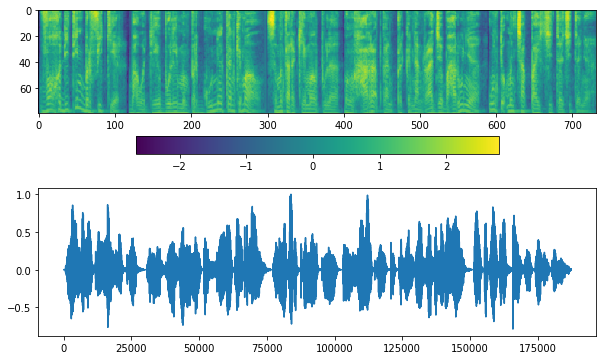

In [20]:
nrows = 2
fig, ax = plt.subplots(nrows = nrows, ncols = 1)
fig.set_figwidth(10)
fig.set_figheight(nrows * 3)
mel_outputs_ = np.reshape(r[1][k], [-1, 80])
im = ax[0].imshow(np.rot90(mel_outputs_), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax[0])
ax[1].plot(r[0][k])
plt.show()

In [22]:
import mp

audios, mels, text_ids = [], [], []

In [23]:
for i in range(0, len(txts), 1000):
    index = min(i + 1000, len(txts))
    b = txts[i: index]
    results = mp.multiprocessing(b, process, cores = 10, returned = True)
    for result in results:
        audios.extend(result[0])
        mels.extend(result[1])
        text_ids.extend(result[2])

  6%|▌         | 6/100 [00:01<00:30,  3.12it/s]

skipped, audio too long


 26%|██▌       | 26/100 [00:09<00:24,  3.02it/s]

skipped, audio too long


 82%|████████▏ | 82/100 [00:28<00:07,  2.46it/s]

skipped, audio too long


 36%|███▌      | 36/100 [00:13<00:23,  2.67it/s]

skipped, audio too long


 46%|████▌     | 46/100 [00:16<00:24,  2.17it/s]

skipped, audio too long


 67%|██████▋   | 67/100 [00:24<00:17,  1.86it/s]

skipped, audio too long


 75%|███████▌  | 75/100 [00:29<00:09,  2.57it/s]

skipped, audio too long


 92%|█████████▏| 92/100 [00:34<00:02,  2.81it/s]

skipped, audio too long


100%|██████████| 92/92 [00:16<00:00,  5.70it/s]


In [24]:
directory = 'male-vits'

In [25]:
!rm -rf {directory}

In [26]:
os.system(f'mkdir {directory}')
directories = ['audios', 'mels', 'text_ids']
for d in directories:
    os.system(f'mkdir {directory}/{d}')

In [29]:
import soundfile as sf
config['sampling_rate']

22050

In [35]:
i = 0
text_ids[i][0]

'muhyiddin berpikir , baru dia boleh mempergunakan cuma , sementara kamu pula mengharapkan perkenan raja baharunya , untuk mencapai cita - citanya ,'

In [36]:
X = []

for i in tqdm(range(len(mels))):
    path = f'{directory}/audios/{i}.wav'
    sf.write(path, audios[i], config['sampling_rate'])
    np.save(f'{directory}/mels/{i}.npy', mels[i])
    X.append((path, text_ids[i][0]))

100%|██████████| 35915/35915 [02:32<00:00, 235.29it/s]


In [37]:
X[0]

('male-vits/audios/0.wav',
 'muhyiddin berpikir , baru dia boleh mempergunakan cuma , sementara kamu pula mengharapkan perkenan raja baharunya , untuk mencapai cita - citanya ,')

In [44]:
from sklearn.model_selection import train_test_split

In [45]:
train_X, test_X = train_test_split(X, test_size = 200)

In [46]:
"""
DUMMY1/LJ045-0096.wav|Mrs. De Mohrenschildt thought that Oswald,
"""

'\nDUMMY1/LJ045-0096.wav|Mrs. De Mohrenschildt thought that Oswald,\n'

In [47]:
os.getcwd()

'/home/husein/speech-bahasa'

In [51]:
x = []
for i in train_X:
    left = os.path.join(os.getcwd(), i[0])
    right = i[1]
    x.append(f'{left}|{right}')
    
with open('male-train-set.txt', 'w') as fopen:
    fopen.write('\n'.join(x))

In [52]:
x = []
for i in test_X:
    left = os.path.join(os.getcwd(), i[0])
    right = i[1]
    x.append(f'{left}|{right}')
    
with open('male-train-set.txt', 'w') as fopen:
    fopen.write('\n'.join(x))